# **Homework 1:** The Hunt for the USS Scorpion (Part I)
## Likelihood and prior odds, risk, decision theory, and intro to Python
STATS348, UChicago, Spring 2023

----------------
Or Goldreich
----------------

## Instructions

The purpose of this homework is to:

* introduce you to Python in Jupyter notebooks
* setup the story of the USS Scorpion, which we will build on in future homeworks
* practice some foundational ideas in Bayesian decision/search theory

We have written and coded a lot of this homework to provide you with structure and examples. 

Please read through it carefully and provide answers to questions where marked. 

Good hunting! 

## Setting

It is May 1968 and the USS _Scorpion_ has just disappeared somewhere in the Atlantic Ocean, likely off the coast of Spain. You are the lone statistician on board the USS _Mizar_, which has been dispatched to find the missing submarine. Your job is to guide the search as best you can, given the data at your disposal.

Before doing anything else, you should import some useful Python libraries.

In [ ]:
# library for dataframes
import pandas as pd

# scientific computing libraries
import numpy as np
import numpy.random as rn
import scipy.stats as st

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

## Magnetometer measurements
The _Mizar_ is pulling a magnetometer behind it underwater as it searches. A magnetometer is an instrument that measures magnetic field in units of nanoTesla (nT). When a magnetometer is nearby a large metal object, like a missing submarine, it (should) produce large values. 

The technician has informed you when there is no large metal object nearby ($Z=0$), the measurements are exponentially distributed:

\begin{align}
P(y_1,\dots,y_n \mid Z=0) = \prod_{i=1}^n \textrm{Expon}(y_i;\,\alpha_0)
\end{align}

The _scale_ parameter $\alpha_0=1$ has been tuned for you to match the background noise in the ocean.

The following function implements the **log likelihood** for the null ($Z=0$) model described above. It uses the [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html) library, which contains many useful functions for probability and statistics.

In [ ]:
def magnetometer_null_log_likelihood(data, alpha0=1.0):
    """Calculate the log likelihood under the null (Z=0) model.
    
    Args:
        data (array-like): Data to calculate the likelihood for.
        alpha0 (float): Shape parameter of the exponential distribution.
                        Default: 1.0 (tuned to match background noise in ocean.
    
    Returns:
        float: Log likelihood of the data under the null model.
    """
    return st.expon(scale=alpha0).logpdf(data).sum()

The technician has further informed you that in previous trials, under controlled settings where the distance to a large metal object is known, the measurements are exponentially distributed, with scale parameter that depends on distance $D$ to the object 

\begin{align}
\underbrace{P(y_i \mid Z=1, D_i)}_{\textrm{complete data likelihood}}= \textrm{Expon}(y_i;\,\underbrace{\alpha_0 + \alpha D_i^{-3}}_{\textrm{scale parameter}})
\end{align}

The coefficient $\alpha$ has been tuned for our purposes to take into account the size and shape of the _Scorpion_, $\alpha=1.23$.

This is the ``complete data likelihood'' since it depends on distance which, in practice, we do not observe. Instead, we would like to work with the marginal likelihood:

\begin{align}
\underbrace{P(y_i \mid Z=1)}_{\textrm{marginal data likelihood}}= \int P(y_i \mid Z=1, D_i) \, P(D_i) \,dD_i 
\end{align}

We don't know where the Mizar was in the (1mi x 1mi) cell when it took each measurement, and don't know where the Scorpion is either, so appealing to the ``principle of insufficient reason'', we will define our prior $P(D_i)$ to be based on the **distribution of distance between two points drawn uniformly at random in a square**. 

We provide a function to sample from this distribution and plot a histogram below.

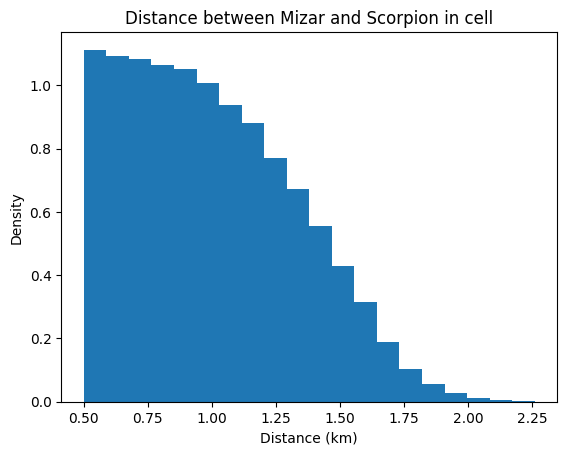

In [ ]:
def sample_distance_in_cell(size=1):
    """Sample the distance in km between the USS Mizar and the USS Scorpion in the (1mi x 1mi) cell.

        - This accounts for 0.25km of average ocean depth

    Args:
        size (int): Number of samples to generate. Default: 1.
    
    Returns:
        array-like: Samples of the distance in kilometers between two points in the (1mi x 1mi) cell.
    """
    mi_to_km = 1.60934
    coords_mizar = mi_to_km * st.uniform.rvs(size=(size, 2)) # the (x,y) coordinates of the mizar
    coords_scorp = mi_to_km * st.uniform.rvs(size=(size, 2)) # the (x,y) coordinates of the scorpion

    distance = np.sqrt(0.25 + np.sum((coords_mizar - coords_scorp) ** 2, axis=1))
    return distance

rn.seed(617)  # do not change this line!
n_samples = 100000
distances = sample_distance_in_cell(size=n_samples)
_ = plt.hist(distances, bins=20, density=True)
_ = plt.xlabel('Distance (km)')
_ = plt.ylabel('Density')
_ = plt.title('Distance between Mizar and Scorpion in cell')


## Approximation
Instead of trying to form the marginal likelihood analytically, we will approximate it as
\begin{align}
\underbrace{P(y_i \mid Z=1)}_{\textrm{marginal data likelihood}}= \int P(y_i \mid Z=1, D_i) \, P(D_i) \,dD_i \approx \sum_{k=1}^K P(y_i \mid Z=1, D=d_k) \, \pi_k
\end{align}
where here we have a discrete set of distances $\{d_k\}_{k=1}^K$, each corresponding to a probability $\pi_k$ where $\sum_{k=1}^K \pi_k=1$. 

## Question 1 [Write] (10pts):
We provide a way to construct $\{d_k\}_{k=1}^K$ and $\{\pi_k\}_{k=1}^K$ from samples below. 

Take time to review each line, and then provide a description of what the function is doing. 

Your answer should include: 

* a high-level description of the algorithm
* explanations of what the numpy functions `linspace` and `histogram` are doing
* what the special indexing `[:-1]` and `[1:]` is doing
* what the output of the function is in terms of the math above

----------------
Overview:

We first sample distances randomly using the function `sample_distance_in_cell`. We then use the function `discrete_approximation` in order to split said samples into $K$ evenly-spaced bins, taking $\{d_k\}_{k=1}^K$ as the centres of said bins, and $\{\pi_k\}_{k=1}^K$ as the proportion of samples from within each bin in our random sampling process.

Details:

The function `linspace` returns an evenly spaced sequence of $K+1$ numbers beginning at the minimal element in `samples`and ending at the maximal element in `samples`.

The function `histogram` returns a list representation (that is, every element of the list corresponding to the number of items in `sample` in the corresponding bin) of a histogram with its bin edges set to those given in the input `bins` - in this case, the arithmetic sequence of length $K+1$ between the extremal values in `samples`, giving us a total of $K$ bins.

The indexing `[:-1]` and `[1:]` is used to exclude the last and first entries respectively. This is useful, as by averaging the walls of each bin in the histogram (by respectively averaging the first and the second for bin $1$, the second and the third for bin $2$ and so forth), we get the centre of each bin as a representative for the distance said bin is supposed to reflect.

The outputs `bin_centers` and `probabilities` are $\{d_k\}_{k=1}^K$ and $\{\pi_k\}_{k=1}^K$ respectively, as `bin_centers` takes a representative distance from each bin, and `probabilities` gives the set of empirically measured probabilities of extracting a distance at random from each of the respective bins.


----------------

<ipython-input-5-193633de753e>:10: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  _ = plt.stem(bin_centers, probabilities, use_line_collection=True)


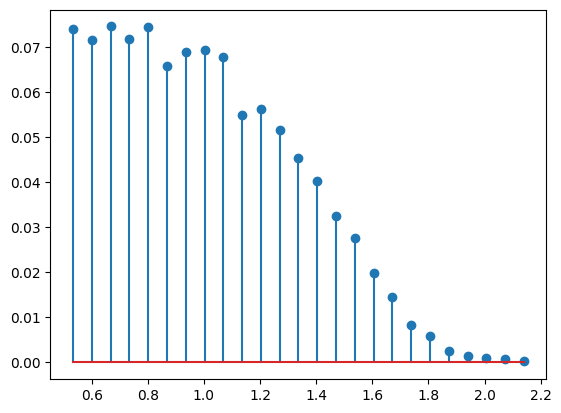

In [ ]:
def discrete_approximation(samples, K):
    bins = np.linspace(np.min(samples), np.max(samples), K+1)
    counts, _ = np.histogram(samples, bins=bins)
    probabilities = counts / counts.sum()
    bin_centers = (bins[:-1] + bins[1:]) / 2
    return bin_centers, probabilities

distances = sample_distance_in_cell(size=10000)
bin_centers, probabilities = discrete_approximation(distances, K=25)
_ = plt.stem(bin_centers, probabilities, use_line_collection=True)


## Question 2a [Code] (20pts):

Use the discrete approximation above to implement the approximate marginal likelihood for $Z=1$. For a single data-point that is:

\begin{align}
P(y_i \mid Z=1) \approx \sum_{k=1}^K \textrm{Expon}(y_i; \alpha_0 + \alpha d_k^{-3}) \pi_k
\end{align}

where recall that $\alpha_0=1$ and $\alpha = 1.23$. 

Your function should accept multiple data points $y_1,\dotsm,y_n$ and return the **log approximate marginal likelihood**:

\begin{equation}
\log P(y_1,\dots,y_n \mid Z=1) \approx \sum_{i=1}^n \log \sum_{k=1}^K \textrm{Expon}(y_i; \alpha_0 + \alpha d_k^{-3}) \pi_k
\end{equation}

In [ ]:
def magnetometer_log_approx_marginal_likelihood(data, distances, pi, alpha=1.23, alpha0=1.0):
    """Calculate the log approximate marginal likelihood under the (Z=1) model.
    
       Args:
        data (array-like): Data to calculate the likelihood for.
        distances (array-like): Distance d_k values in the discrete approximation.
        pi (array-like): Probability pi_k values in the discrete approximation.
        alpha (float): Coefficient on distance.
                       Default: 1.23 (tuned to match Scorpion).
        alpha0 (float): Background noise level.
                        Default: 1.0 (tuned to match background noise in ocean).
    
    Returns:
        float: Log approximate marginal likelihood of the data under the (Z=1) model.
    """

    # Your code here #
    n = len(data)
    k = len(distances)
    app_lik = np.zeros(n)
    for i in range(n):
      for j in range(k):
        app_lik[i] = app_lik[i]+(st.expon(scale=alpha0+alpha*(distances[j])**(-3)).pdf(data[i])*pi[j])
    return np.log(app_lik).sum()

## Question 2b [Code] (10pts):

Implement a function that computes the likelihood odds (LO) ratio for an input set of data

\begin{equation}
\textrm{LO}(y_1,\dots,y_n) = \frac{P(y_1,\dots,y_n \mid Z=1)}{P(y_1,\dots,y_n \mid Z=0)}
\end{equation}

Your function should call the functions
* `magnetometer_null_log_likelihood`
* `magnetometer_log_approx_marginal_likelihood`

Your function should take `data` as an argument. If you add other arguments, then add a description of them in the docstring.

In [ ]:
def magnetometer_likelihood_odds(data, distances, pi):
    """Calculate the likelihood odds ratio for the magnetometer data.
    
    Args:
        data (array-like): Data to calculate the likelihood odds for.

        OTHER ARGS: You may need to add other arguments to this function.
        distances (array-like): Distance d_k values in the discrete approximation.
        pi (array-like): Probability pi_k values in the discrete approximation.
    
    Returns:
        float: Likelihood odds.
    """
    
    # Your code here #
    return np.exp(magnetometer_log_approx_marginal_likelihood(data, distances, pi)-magnetometer_null_log_likelihood(data))

## Question 2c [Write] (5pts):

Run the following code to calculate the likelihood odds on the magnetometer data that just arrived. 

* Explain what the data say about the hypothesis $Z=1$.

----------------
The likelihood odds are $0.1$, which means that these samples are ten times less likely to have come up as a result of the alternate as compared to the null.

----------------

* Explain what the data say about the hypothesis $Z=1$ when also taking into account the Captain's prior odds of 1/20.

----------------
The data is more optimistic than the captain - following our data, the odds are only $10$ to $1$ against.

----------------

In [ ]:
data = np.load('magnetometer_data.npy')
print('Likelihood odds: {:.2f}'.format(magnetometer_likelihood_odds(data, bin_centers, probabilities)))

Likelihood odds: 0.10


## Do we send the divers?
In this problem, we will use Bayesian decision theory to make a principled decision about whether to send divers to search for the Scorpion. Our decision will integrate 
* the likelihood odds of the magnetometer data
* the Captain's prior odds
* our loss function
* the ``Search effectiveness probability''

## Question 3a [Math] (20pts)

Recall that our loss function $\ell(a,z)$ is a function of whether or not we search $a=0,1$ and whether or not the Scorpion is in the cell $z=0,1$.

|  $\ell(a,z)$ | $z=0$ | $z=1$ |
| ----- | -------- | -------- |
| $a=0$ | $L_{\textrm{TN}}$   | $L_{\textrm{FN}}$   |
| $a=1$ | $L_{\textrm{FP}}$   | $L_{\textrm{TP}}$   |

Further recall that the ``search effectiveness probability'' (SEP) is $q = P(\tilde{Z}=1 \mid Z=1, a=1)$ where $\tilde{Z}=1$ denotes successfully finding the Scorpion and $\tilde{Z}=0$ denotes failing to find it. Incorporating the SEP into our decision problem effectively means re-defining the loss associated with the true positive cell $L_{\textrm{TP}}$ in terms of losses associated with "successful" and "failed" true positives:

\begin{equation}
L_{\textrm{TP}} = q L_{\textrm{STP}} + (1-q) L_{\textrm{FTP}} 
\end{equation}

Finally, recall the definition of **Bayesian expected loss**:
\begin{equation}
\rho(\pi^*, a) = E_{Z \sim \pi^*}[\ell(a,Z)]
\end{equation}
where the expectation is with respect to our posterior distribution $\pi^* = P(Z=1\mid y_1, \dots, y_n)$.

**Derive the threshold $T$ on the likelihood odds, which if exceeded means that we should send the divers:**

\begin{align}
a^* = \begin{cases}
1 &\textrm{if } \frac{P(y_1,\dots,y_n \mid Z=1)}{P(y_1,\dots,y_n \mid Z=0)} > T \\
0 &\textrm{otherwise }
\end{cases}
\end{align}

----------------
We are interested in minimising the Bayesian expected loss.

If we choose not to search, this is:
$$\rho_0=\rho\left(\pi^*,0\right)=\left(1-\pi^*\right)L_{TN}+\pi^*L_{FN}$$

If we choose to search, this is:
$$\rho_1=\rho\left(\pi^*,1\right)=\pi^*L_{TP}+\left(1-\pi^*\right)L_{FP}=\pi^*\left(qL_{STP}+\left(1-q\right)L_{FTP}\right)+\left(1-\pi^*\right)L_{FP}$$

Then searching minimises this argument if:
$$\rho_1<\rho_0\iff\left(1-\pi^*\right)L_{TN}+\pi^*L_{FN}<\pi^*\left(qL_{STP}+\left(1-q\right)L_{FTP}\right)+\left(1-\pi^*\right)L_{FP}\iff\pi^*\left(qL_{STP}+\left(1-q\right)L_{FTP}-L_{FN}\right)>\left(1-\pi^*\right)\left(L_{TN}-L_{FP}\right)\iff\frac{\pi^*}{1-\pi^*}>\frac{L_{TN}-L_{FP}}{qL_{STP}+\left(1-q\right)L_{FTP}-L_{FN}}$$

If we now denote the prior distribution $\pi=P\left(Z=1\right)$ then using Bayes' theorem, we get:

$$\frac{P(y_1,\ldots,y_n \mid Z=1)}{P(y_1,\ldots,y_n \mid Z=0)}=\frac{\frac{P(Z=1\,\mid\,y_1,\ldots,y_n)P\left(y_1,\ldots,y_n\right)}{P\left(Z=1\right)}}{\frac{P(Z=0\,\mid\,y_1,\ldots,y_n)P\left(y_1,\ldots,y_n\right)}{P\left(Z=0\right)}}=\frac{\pi^*}{1-\pi^*}\cdot\frac{1-\pi}{\pi}$$

Plugging in the requirement for minimising the Bayesian expected loss, we get:

$$\frac{P(y_1,\ldots,y_n \mid Z=1)}{P(y_1,\ldots,y_n \mid Z=0)}>\frac{L_{TN}-L_{FP}}{qL_{STP}+\left(1-q\right)L_{FTP}-L_{FN}}\cdot\frac{1-\pi}{\pi}$$

So $T=\frac{L_{TN}-L_{FP}}{qL_{STP}+\left(1-q\right)L_{FTP}-L_{FN}}\cdot\frac{1-\pi}{\pi}$.

We also observe that $\frac{1-\pi}{\pi}$ is the reciprocal of the prior odds.

----------------

## Question 3b [Code] (10pts)

Implement a function that calculates this threshold. 

Your function should take as an argument a loss function which is a Python dictionary (as shown below).

In [ ]:
loss_func = {
    'TN': 1,  # true negative
    'FP': 25, # false positive
    'FN': 100, # false negative
    'STP': 1, # successful true positive
    'FTP': 10 # failed true positive
             }

def likelihood_odds_threshhold(loss_func, prior_odds, sep):
    """Calculate the likelihood odds threshold for a given loss function and prior odds.
    
    Args:
        loss_func (dict): Dictionary of loss values.
        prior_odds (float): Prior odds.
        sep (float): Search effectiveness probability.
    """
    
    # Your code here
    return (loss_func["TN"]-loss_func["FP"])/((sep*loss_func["STP"]+(1-sep)*loss_func["FTP"]-loss_func["FN"])*prior_odds)

## Question 3c [Write] (10pts)

Using the likelihood odds of the magnetometer data, the Captain's prior odds of $\tfrac{1}{20}$, and a SEP of $0.75$, and the loss function given below, use your code to answer the question: **should we send the divers?**

----------------
We get a threshhold of $12.874$, which is far greater than the likelihood odds ratio we found earlier, which is $0.1$. This means that we do not cross said threshhold, and elect not to send the divers.

----------------

In [ ]:
loss_func = {
    'TN': 1,  # true negative
    'FP': 15, # false positive
    'FN': 25, # false negative
    'STP': 1, # successful true positive
    'FTP': 10 # failed true positive
             }

# Your code here
likelihood_odds_threshhold(loss_func, 0.05, 0.75)

12.873563218390803

## Question 3d [Write] (15pts)

Explore some of the parameter settings (e.g., loss function, SEP, prior) and find a setting that changes your answer. Explain what the parameter changes are, and why they change the answer. Show the code below that led to your conclusion.

----------------
To change the answer, we are interested in reducing the threshhold. This can be done with several tools:

* The prior odds are inversely linked with the threshhold, so we can increase those.
* Given the reasonable assumption that $L_{STP}<L_{FTP}$, SEP is inversely linked with the threshhold, so we can increase it as well.
* Having a higher tolerance to failed missions in comparison to missed opportunities for success, which could be understood as a higher loss score for false negatives and/or lower loss scores for false positives and failed true positives.

We employ all of these as follows:

* Increase the prior odds to $\frac14$.
* Increase SEP to $0.95$.
* Increase $L_{FN}$ to $125$.
* Decrease $L_{FP}$ and $L_{FTP}$ to $4$.

This results in a threshhold of $\sim0.097$, which is below the likelihood odds, that are $0.1$.

----------------

In [ ]:
# Your code here
loss_func = {
    'TN': 1,  # true negative
    'FP': 4, # false positive
    'FN': 125, # false negative
    'STP': 1, # successful true positive
    'FTP': 4 # failed true positive
             }

likelihood_odds_threshhold(loss_func, 0.25, 0.95)


0.09689140088817118